# Aaaahhhhhhhh
Alle guten Dinge sind zwei, also mal schauen ob ichs jetzt richtig verstanden hab.

- Fix geometry
- Vary the B.n created by plasma (B_external_normal)
- Analyze the impact

virtual casing data file: tests/test_files/vcasing_W7-X_without_coil_ripple_beta0p05_d23p4_tm_reference.nc
Loading saved virtual casing result


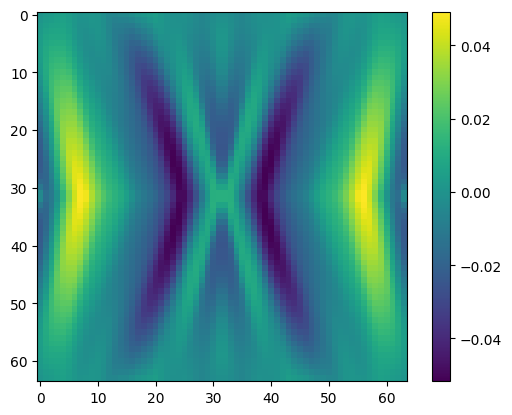

Text(0.5, 1.0, 'Spectrum of the loaded B.n')

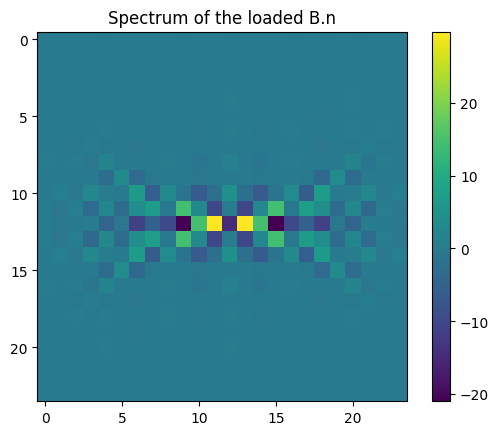

In [16]:
import os
from datetime import datetime
from pathlib import Path
import numpy as np
from scipy.optimize import minimize
from simsopt.field import BiotSavart, Current, coils_via_symmetries
import simsopt.geo
from simsopt.mhd import VirtualCasing, Vmec
from simsopt.objectives import QuadraticPenalty, SquaredFlux
from simsopt.util import in_github_actions


# Major radius for the initial circular coils:
R0 = 5.5

# Minor radius for the initial circular coils:
R1 = 1.25
R1_reactor = R0/5

# Number of Fourier modes describing each Cartesian component of each coil:
order = 9

# Number of iterations to perform:
MAXITER = 100

# File for the desired boundary magnetic surface:
TEST_DIR = "tests/test_files"
filename = 'wout_W7-X_without_coil_ripple_beta0p05_d23p4_tm_reference.nc'
vmec_file = TEST_DIR +"/"+ filename

# Resolution on the plasma boundary surface:
# nphi is the number of grid points in 1/2 a field period.
nphi = 32
ntheta = 64

# Resolution for the virtual casing calculation:
vc_src_nphi = 80
# (For the virtual casing src_ resolution, only nphi needs to be
# specified; the theta resolution is computed automatically to
# minimize anisotropy of the grid.)

#######################################################
# End of input parameters.
#######################################################

# Directory for output
out_dir = Path("output")
out_dir.mkdir(parents=True, exist_ok=True)

# Once the virtual casing calculation has been run once, the results
# can be used for many coil optimizations. Therefore here we check to
# see if the virtual casing output file alreadys exists. If so, load
# the results, otherwise run the virtual casing calculation and save
# the results.
head, tail = os.path.split(vmec_file)
vc_filename = os.path.join(head, tail.replace('wout', 'vcasing'))
print('virtual casing data file:', vc_filename)
if os.path.isfile(vc_filename):
    print('Loading saved virtual casing result')
    vc = VirtualCasing.load(vc_filename)
else:
    # Virtual casing must not have been run yet.
    print('Running the virtual casing calculation')
    vc = VirtualCasing.from_vmec(vmec_file, src_nphi=vc_src_nphi, trgt_nphi=nphi, trgt_ntheta=ntheta)

import matplotlib.pyplot as plt
stacked_img = np.vstack([vc.B_external_normal, np.flip(vc.B_external_normal, axis=0)])
extended_img = np.hstack([stacked_img, np.flip(stacked_img, axis=1)])
plt.imshow(extended_img)
plt.colorbar()
plt.show()
plt.imshow(np.real(np.fft.ifftshift(np.fft.fft2(extended_img))[20:-20,20:-20]))
plt.colorbar()
plt.title("Spectrum of the loaded B.n")

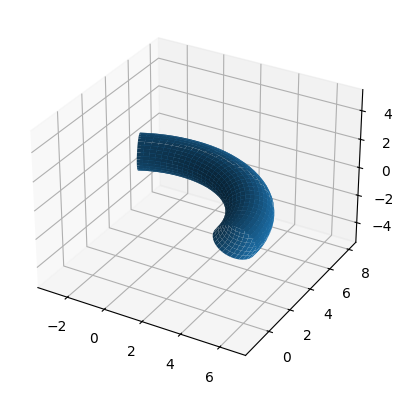

Aspect ratio 5.0


In [17]:
nfp = 3
s = simsopt.geo.SurfaceRZFourier.from_nphi_ntheta(32, 32, "field period", nfp )
s.set_rc(0,0,R0)
s.set_rc(1,0,R1_reactor)
s.set_zs(1,0,R1_reactor)
s.plot()
print("Aspect ratio",R0/R1_reactor)

In [18]:
def plot_modes(image_mn, **kwargs):
  extent = (-image_mn.shape[1]/2, image_mn.shape[1]/2, image_mn.shape[0]-0.5,-0.5)

  plt.imshow(image_mn, extent=extent, **kwargs)
  plt.colorbar()
  plt.ylabel("m")
  plt.xlabel("n")

Only contains the even terms, for odd terms the imaginary equivalent has to be used! 

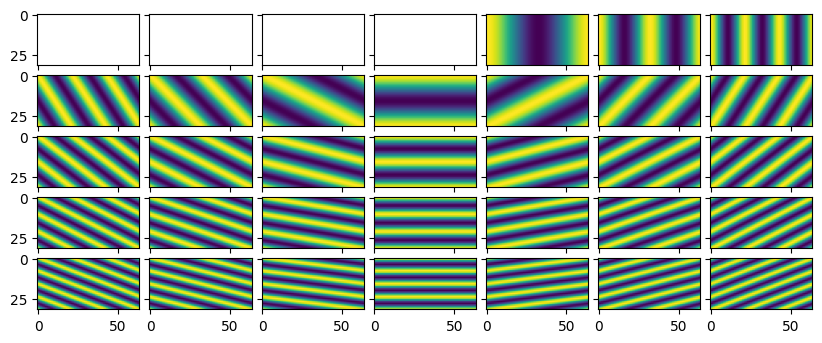

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

Mpol_max = 5
Ntor_max = 4

images = []
ms = []
ns = []
for m in range(Mpol_max):
  for sig_n in [-1, 1]:
    if m==0 and sig_n==-1:
      images.extend([None]*(Ntor_max-1))
      continue
    for n in range(Ntor_max) if sig_n>0 else reversed(range(1,Ntor_max)):
      if m==0 and n==0:
         images.append(None)
         continue
      Bn_fspace = np.zeros((nphi, ntheta))
      Bn_fspace[m][n*sig_n] = nphi*10
      B_external_normal = np.fft.ifft2(Bn_fspace)

      images.append(np.real(B_external_normal))
      ms.append(m)
      ns.append(n*sig_n)

fig = plt.figure(figsize=(Mpol_max*2, Ntor_max*3))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(Mpol_max, Ntor_max*2-1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    if im is not None:
      ax.imshow(im)
plt.show()

images = list(filter(lambda x: x is not None, images))

In [20]:
import ipywidgets

def plot_coil_complexities(campaign_folder):
    resfilepaths = os.listdir(campaign_folder)

    results = [simsopt.load(os.path.join(campaign_folder, resfile)) for resfile in resfilepaths]
    mmax = 0
    nmax = 0
    for res in results:
        mmax = max(mmax, res["m"])
        nmax = max(nmax, res["n"])
    heatmap_convergence_mean = np.zeros((mmax+1, nmax*2+1))
    heatmap_convergence_max = np.zeros((mmax+1, nmax*2+1))
    coil_complexity_map = np.zeros_like(heatmap_convergence_mean)
    J_map = np.zeros_like(heatmap_convergence_mean)
    
    for res in results:
        heatmap_convergence_mean[res["m"]][nmax+res["n"]] = np.mean(np.abs(res["BdotN"]))
        heatmap_convergence_max[res["m"]][nmax+res["n"]] = np.max(res["BdotN"])
        J_map[res["m"]][nmax+res["n"]] = res["J"]
        
        if res["J"] < B_DOT_N_THRESHOLD:
            coil_complexity_map[res["m"]][nmax+res["n"]] = res["complexity"]
        else:
            coil_complexity_map[res["m"]][nmax+res["n"]] = np.nan 
    plt.subplot(221)
    plot_modes(heatmap_convergence_mean)
    plt.title("Mean B.n error")
    plt.subplot(222)
    plot_modes(heatmap_convergence_max)
    plt.title("Max B.n error")
    plt.subplot(223)
    plot_modes(coil_complexity_map)
    plt.title("coil_complexity_map")
    plt.subplot(224)
    plot_modes(J_map)
    plt.title("J")
    plt.savefig("complexity.png")

    # for res in results:
    #     simsopt.geo.plot(res["coils"])

directories = [os.path.join(out_dir, name) for name in os.listdir(out_dir) if os.path.isdir(os.path.join(out_dir, name))]
ipywidgets.interact(plot_coil_complexities, campaign_folder=ipywidgets.Dropdown(options=reversed(directories)))


interactive(children=(Dropdown(description='campaign_folder', options=('output/2024-05-14--15-51', 'output/202…

<function __main__.plot_coil_complexities(campaign_folder)>

## Sensitivity analysis

### Spectrum generation functions

In [21]:
def image_from_magn_and_phase(magnitudes, phases, image_size=(64, 64)):
    # Construct frequency domain signal
    # magnitudes[0] = 0
    freq_signal = magnitudes * np.exp(1j * phases)
    
    # Perform 2D inverse Fourier transform
    image = np.fft.ifft2(freq_signal, s=image_size)

    # plt.subplot(131)
    # plt.imshow(np.fft.fftshift(np.imag(image)))
    # plt.subplot(132)
    # plt.imshow(np.fft.fftshift(np.real(image)))

    # Take real part of the image
    return np.imag(image)

# Generate random magnitudes and phases
magnitudes = np.random.rand(Mpol_max, Ntor_max)
phases = np.random.rand(Mpol_max, Ntor_max)  * 2 * np.pi
image_from_magn_and_phase(magnitudes, phases)

array([[-9.33602587e-05, -5.73172246e-05, -3.38540083e-05, ...,
        -2.61672207e-04, -1.98179016e-04, -1.41014459e-04],
       [-3.53965178e-05, -1.00390891e-05,  1.53431065e-06, ...,
        -1.87906724e-04, -1.26226196e-04, -7.45443026e-05],
       [-1.18608744e-05,  5.21888079e-06,  8.91693087e-06, ...,
        -1.45853030e-04, -8.84596030e-05, -4.32143544e-05],
       ...,
       [-4.61827781e-04, -4.09853683e-04, -3.56064805e-04, ...,
        -5.79640988e-04, -5.49499860e-04, -5.09305769e-04],
       [-3.14370539e-04, -2.61825533e-04, -2.13895301e-04, ...,
        -4.72338408e-04, -4.22840230e-04, -3.69046741e-04],
       [-1.87855665e-04, -1.41658089e-04, -1.04977200e-04, ...,
        -3.60652202e-04, -3.00483333e-04, -2.41711212e-04]])

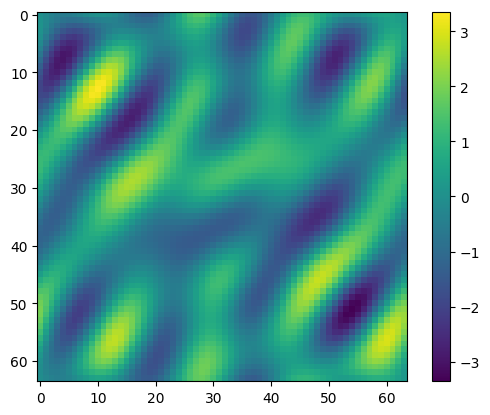

4096.0

In [40]:
from skimage.filters import window

def image_from_spectral_radius(spectral_radius:float, magnitude = 1, image_size=(64, 64), normalization=None):
    if normalization is None:
        normalization = np.ones(image_size)
    # Construct frequency domain signal
    magnitudes = np.random.rand(*image_size)
    magnitudes[0,0] = 0
    phases = np.random.rand(*image_size) * 2 * np.pi
    freq_signal = magnitudes * np.exp(1j * phases)

    y, x = np.indices(image_size)
    r = np.sqrt(x**2 + y**2)
    # w = window(spectral_radius, image_size)
    # plt.imshow(np.fft.ifftshift(w))
    # plt.show()
    freq_signal = np.where(r<=spectral_radius, freq_signal, np.zeros_like(freq_signal))
    
    # Perform 2D inverse Fourier transform
    image = np.real(np.fft.ifft2(1j*freq_signal.imag, s=image_size)/normalization)

    return image * magnitude * (image_size[0]* image_size[1]) / np.sum(np.abs(image))


plt.imshow(image_from_spectral_radius(5))
plt.colorbar()
plt.show()
np.sum(np.abs(image_from_spectral_radius(3)))

### Define and run the optimization problem

In [43]:
out_dir_campaign = out_dir / datetime.now().strftime("%Y-%m-%d--%H-%M") #For the current experimental campaign
out_dir_campaign.mkdir(parents=True, exist_ok=True)
print(out_dir_campaign)

def problem(spectral_radius, magnitude, complex_surface=False, stellsym=True, batch=False):
    nfp = 4
    if complex_surface:
        nfp = 1
    

    if stellsym:
        nphi_asym = nphi
        ncoils = 3
    else:
        nphi_asym = nphi*2
        ncoils = 6

    # Generate Geometry from X2 parameter
    if complex_surface:
        filename = "tests/test_files/input.LandremanPaul2021_QA"
        s = simsopt.geo.SurfaceRZFourier.from_vmec_input(filename, nphi=nphi_asym, ntheta=ntheta)
        s.extend_via_projected_normal(0.1)
    else:
        s = simsopt.geo.SurfaceRZFourier.from_nphi_ntheta(nphi_asym, ntheta, range="half period" if stellsym else "field period", nfp=nfp)
        # s = simsopt.geo.SurfaceRZFourier.from_nphi_ntheta(nphi_asym, ntheta, range="field period", nfp=nfp)
        
        s.change_resolution(5, 5)
        
        s.set_rc(0,0,R0)
        s.set_rc(1,0,R1_reactor)
        s.set_zs(1,0,R1_reactor)
        # mask = s.rc < 0.0
        # mask[0,:s.ntor+1] = True
        # s.rc[~mask] += X2
    
    normalization_weight = np.sqrt(s.area()/(2 * np.pi**2 *np.linalg.norm(s.normal(), axis=-1)))
    # , normalization = normalization_weight
    B_external_normal = image_from_spectral_radius(spectral_radius, magnitude, normalization_weight.shape)

    if(not batch):
        plt.figure()
        plt.subplot(221)
        plt.imshow(B_external_normal)
        plt.colorbar()
        plt.title("Target field")

    CS_THRESHOLD = 0.05
    # Create the initial coils:
    base_curves = simsopt.geo.create_equally_spaced_curves(ncoils, s.nfp, stellsym=stellsym, R0=s.major_radius(), R1=s.minor_radius()*(1+5*CS_THRESHOLD), order=order)
    # base_curves = simsopt.geo.create_equally_spaced_curves(ncoils, s.nfp, stellsym=stellsym, R0=1, R1=0.5, order=order)
    base_currents = [Current(5e6 / ncoils * 1e-5) * 1e5 for _ in range(ncoils)]

    # Above, the factors of 1e-5 and 1e5 are included so the current
    # degrees of freedom are O(1) rather than ~ MA.  The optimization
    # algorithm may not perform well if the dofs are scaled badly.

    coils = coils_via_symmetries(base_curves, base_currents, s.nfp, stellsym=stellsym)
    bs = BiotSavart(coils)
    bs.set_points(s.gamma().reshape((-1, 3)))
    curves = [c.curve for c in coils]

    # Form the total objective function.
    B_DOT_N_THRESHOLD = 0.05  # 10% error allowed
    LENGTH_WEIGHT = 0.05
    TARGET_LENGTH = 1.0*s.minor_radius() * 2 * np.pi
    CC_WEIGHT = 1.0
    CC_THRESHOLD = 0.02
    CURVATURE_THRESHOLD = 0.02
    CURVATURE_WEIGHT = 1e-3

    MSC_THRESHOLD = 0.2
    MSC_WEIGHT = 1e-3
        
    Jf_initial = SquaredFlux(s, BiotSavart([]), target=B_external_normal).J() # Scalar evaluation to create the percentage error threshold

    Jf = 2*SquaredFlux(s, bs, target=B_external_normal)
    Jf_threshold =  QuadraticPenalty(Jf, B_DOT_N_THRESHOLD*Jf_initial, "max")
    Jls = LENGTH_WEIGHT*sum([QuadraticPenalty(simsopt.geo.CurveLength(c), TARGET_LENGTH) for c in base_curves])
    Jccdist = CC_WEIGHT*simsopt.geo.CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=ncoils)
    Jcsdist = simsopt.geo.CurveSurfaceDistance(curves, s, CS_THRESHOLD)
    Jcs = CURVATURE_WEIGHT * sum([simsopt.geo.LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_curves])
    Jmscs = MSC_WEIGHT * sum( [QuadraticPenalty(simsopt.geo.MeanSquaredCurvature(c), MSC_THRESHOLD, "max") for c in base_curves])
    Jcs_nothresh = CURVATURE_WEIGHT * sum([simsopt.geo.LpCurveCurvature(c, 2) for c in base_curves])
    Jmscs_nothresh = MSC_WEIGHT * sum([simsopt.geo.MeanSquaredCurvature(c) for c in base_curves])
    
    JF = Jf  + Jls + Jccdist  + Jcsdist  + Jcs + Jmscs
       

    def fun(dofs):
        JF.x = dofs
        J = JF.J()
        grad = JF.dJ()
        return J, grad

    res = minimize(fun, JF.x, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300, 'ftol': 1e-20, 'gtol': 1e-20}, tol=1e-20)

    # Writing to file
    Bbs = bs.B().reshape((nphi_asym, ntheta, 3))
    BdotN = B_external_normal - np.sum(Bbs * s.unitnormal(), axis=2)
    pointData = {"B_N": BdotN[:, :, None]}
    s.to_vtk(out_dir / "surf_opt", extra_data=pointData)
    simsopt.geo.curves_to_vtk(curves, out_dir / "curves_opt")
    
    def get_unique_filename(filename):
        if not os.path.exists(filename):
            return filename

        # Split the filename and its extension
        name, ext = os.path.splitext(filename)

        # Initialize counter
        counter = 1

        # Increment the filename until it is unique
        while True:
            new_filename = f"{name}_{counter}{ext}"
            if not os.path.exists(new_filename):
                return new_filename
            counter += 1

    complexity = (Jls.J()+Jccdist.J()+Jcsdist.J()+ Jcs_nothresh.J() + Jmscs_nothresh.J()) # only the coil complexity terms, without the magnetic field residual
    simsopt.save({  "spectral_radius":spectral_radius,
                    "magnitude":magnitude,
                    "J": JF.J(),
                    "complexity": complexity,
                    "coils":coils,
                    "surf":s,
                    "B_external_normal":B_external_normal,
                    "BdotN":BdotN}, 
                    get_unique_filename(out_dir_campaign/"sens_result.json"))
    
    if(not batch):
        plt.subplot(223)
        plt.imshow(np.real(np.sum(Bbs * s.unitnormal(), axis=2)))
        plt.colorbar()
        plt.title("B.n realized")

        plt.subplot(122)
        plt.imshow(np.real(BdotN))
        plt.colorbar()
        plt.title("B.n Diff")

        plt.show()

        simsopt.geo.plot([s]+curves)

        print("Jf",Jf.J())
        print("Jf_threshold",Jf_threshold.J())
        print("Jls",Jls.J())
        print("Jccdist",Jccdist.J())
        print("Jcsdist",Jcsdist.J())
        print("Jcs",Jcs.J())
        print("Jmscs",Jmscs.J())

    return complexity, np.mean(np.abs(BdotN))

counter = 0
def debug_func(X,X2, **kwargs):
    global counter

    plt.subplot(4,4,(counter%16+1))
    plt.imshow(image_from_magn_and_phase(X, X2))
    counter+=1
    if(counter%16 == 0):
        plt.colorbar()
        plt.show()
        
    return np.mean(X), np.max(X)

def wrapped_problem(X: np.ndarray, func=problem) -> np.ndarray:
    N, D = X.shape
    results = []
    for i in range(N):
        print(f"{i+1}/{N}")
        results.append(func(X[i,0], 0.25, batch=True))

    return np.array(results)

output/2024-05-22--13-00


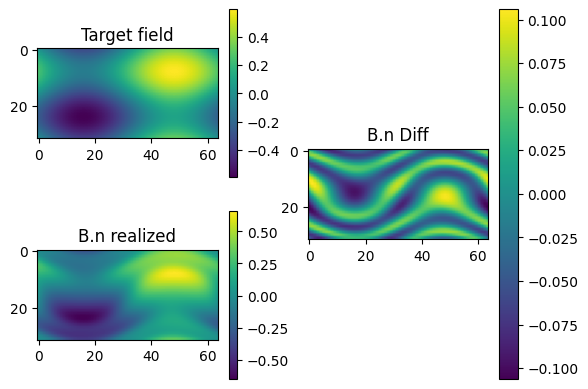

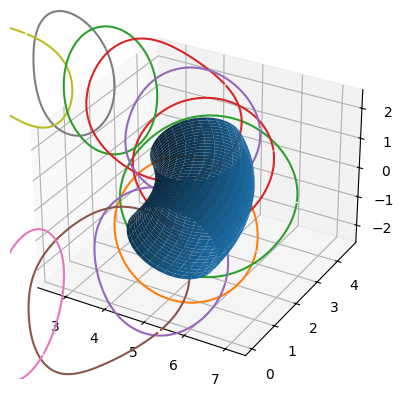

Jf 0.6217349904874543
Jf_threshold 0.0030469057392904352
Jls 1.8489835017945642
Jccdist 0.0
Jcsdist 0
Jcs 0.005109434465418827
Jmscs 1.9866534442769695e-05


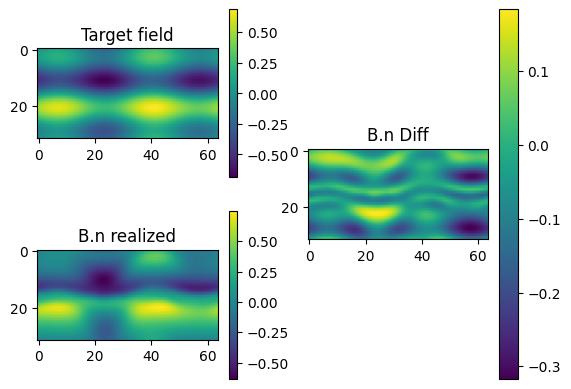

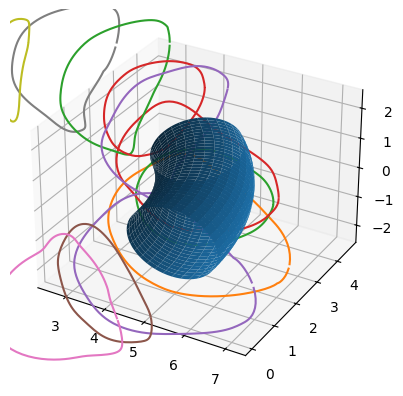

Jf 2.882374097487356
Jf_threshold 2.7046313966153335
Jls 1.999297556581414
Jccdist 0.0
Jcsdist 0
Jcs 0.011169086858905082
Jmscs 0.0003153795112674207


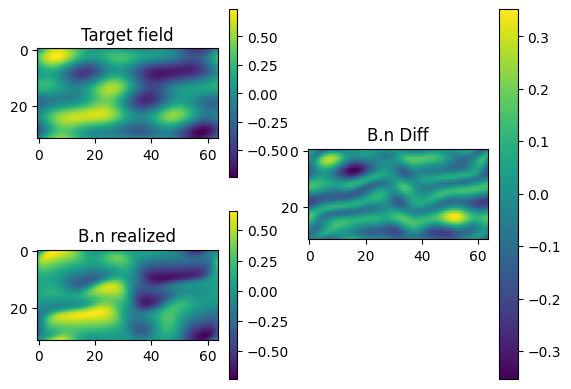

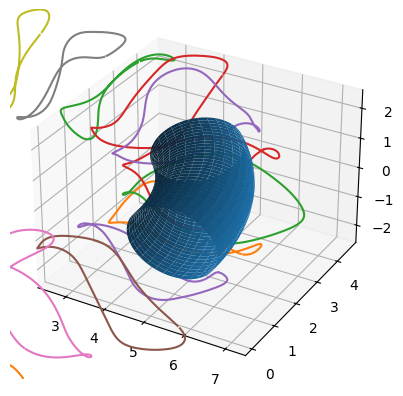

Jf 2.4496253472557616
Jf_threshold 1.7415537984396627
Jls 2.0927349820867054
Jccdist 0.0
Jcsdist 0
Jcs 0.014042432602231604
Jmscs 0.0005595183669945001


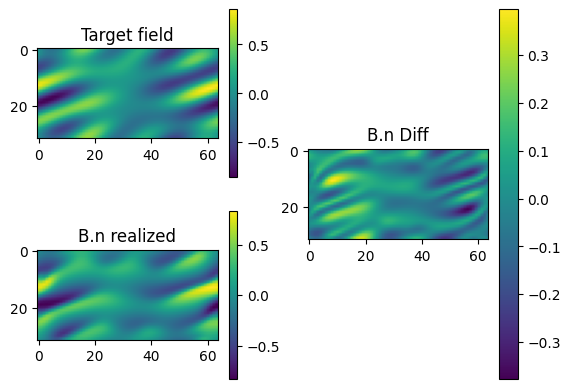

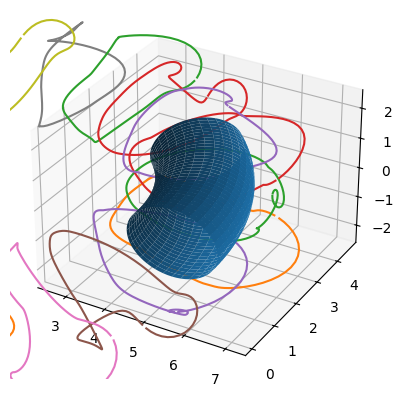

Jf 3.1188805025546276
Jf_threshold 3.07457263456492
Jls 3.7350214109871516
Jccdist 0.0
Jcsdist 0
Jcs 0.022476770585834204
Jmscs 0.0012541719822870016


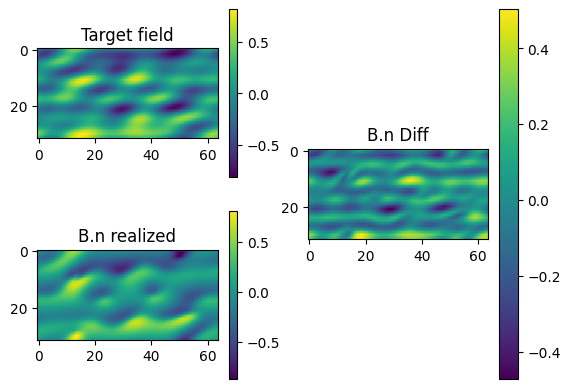

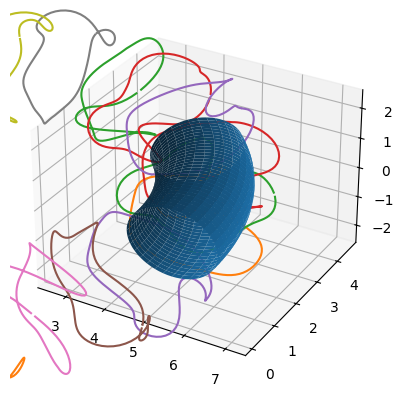

Jf 5.450901421083364
Jf_threshold 11.992529872571168
Jls 3.4240063369123934
Jccdist 0.0
Jcsdist 0
Jcs 0.038293707779739235
Jmscs 0.004419761028077331


(Array(3.46894641, dtype=float64), 0.12064778573076193)

In [44]:
problem(1, 0.25)
problem(2, 0.25)
problem(3, 0.25)
problem(4, 0.25)
problem(5, 0.25)

In [45]:
import numpy as np
from SALib import ProblemSpec

sp = ProblemSpec({
        "names":  ["spectral_radius"],
        "bounds": [[1, 12]],
        "outputs": ["coil_complexity", "BdotN_mean"],
    })

sp.sample_sobol(256, calc_second_order=True).evaluate(wrapped_problem).analyze_sobol()

1/1024
2/1024
3/1024
4/1024
5/1024
6/1024
7/1024
8/1024
9/1024
10/1024
11/1024
12/1024
13/1024
14/1024
15/1024
16/1024
17/1024
18/1024
19/1024
20/1024
21/1024
22/1024
23/1024
24/1024
25/1024
26/1024
27/1024
28/1024
29/1024
30/1024
31/1024
32/1024
33/1024
34/1024
35/1024
36/1024
37/1024
38/1024
39/1024
40/1024
41/1024
42/1024
43/1024
44/1024
45/1024
46/1024
47/1024
48/1024
49/1024
50/1024
51/1024
52/1024
53/1024
54/1024
55/1024
56/1024
57/1024
58/1024
59/1024
60/1024
61/1024
62/1024
63/1024
64/1024
65/1024
66/1024
67/1024
68/1024
69/1024
70/1024
71/1024
72/1024
73/1024
74/1024
75/1024
76/1024
77/1024
78/1024
79/1024
80/1024
81/1024
82/1024
83/1024
84/1024
85/1024
86/1024
87/1024
88/1024
89/1024
90/1024
91/1024
92/1024
93/1024
94/1024
95/1024
96/1024
97/1024
98/1024
99/1024
100/1024
101/1024
102/1024
103/1024
104/1024
105/1024
106/1024
107/1024
108/1024
109/1024
110/1024
111/1024
112/1024
113/1024
114/1024
115/1024
116/1024
117/1024
118/1024
119/1024
120/1024
121/1024
122/1024
123/1024
1

KeyboardInterrupt: 

In [ ]:
%matplotlib widget
import pandas as pd
# https://gsa-module.readthedocs.io/en/stable/implementation/sobol_indices.html
sp.plot()
sp.heatmap()
complexity_Si, BdotN_Si = sp.to_df()
complexity_Si[0].to_csv(out_dir_campaign/"total_Si_complex_landreman.csv")
BdotN_Si[0].to_csv(out_dir_campaign/"total_Si_BdotN_landreman.csv")
complexity_Si[1].to_csv(out_dir_campaign/"first_Si_complex_landreman.csv")
BdotN_Si[1].to_csv(out_dir_campaign/"first_Si_BdotN_landreman.csv")
complexity_Si[2].to_csv(out_dir_campaign/"second_Si_complex_landreman.csv")
BdotN_Si[2].to_csv(out_dir_campaign/"second_Si_BdotN_landreman.csv")

In [ ]:
sp

## CSV analysis

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import ipywidgets

def implot_df(df:pd.DataFrame, **kwargs):
  mmesh, nmesh = np.meshgrid(np.arange(Mpol_max), np.arange(Ntor_max))
  map_to_mn = {f"M{i}": (m, n) for m, n, i in zip(mmesh.flatten(), nmesh.flatten(), range(Ntor_max*Mpol_max))}

  df["mn"] = df.index.to_series().map(map_to_mn)
  df["m"] = df["mn"].apply(lambda x: x[0])
  df["n"] = df["mn"].apply(lambda x: x[1])

  return px.bar(df, x="m", y=df.columns[0], color="n",facet_col="n", error_y=df.columns[1], barmode="group", **kwargs)
  return px.scatter(df, "n","m", color=df.columns[0], size=df.columns[1], title="Impact of geometry coefficients")

analysis_folder = ""
def load_dataframes(campaign_folder):
  global analysis_folder, first_Si_complexity, total_Si_complexity, total_Si_BdotN, first_Si_BdotN
  try:
    first_Si_complexity = pd.read_csv(os.path.join(campaign_folder,"first_Si_complex_landreman.csv"), index_col=0)
    total_Si_complexity = pd.read_csv(os.path.join(campaign_folder,"total_Si_complex_landreman.csv"), index_col=0)
    total_Si_BdotN = pd.read_csv(os.path.join(campaign_folder,"total_Si_BdotN_landreman.csv"), index_col=0)
    first_Si_BdotN = pd.read_csv(os.path.join(campaign_folder,"first_Si_BdotN_landreman.csv"), index_col=0)

    analysis_folder = campaign_folder

    implot_df(total_Si_complexity, title="Coil Complexity").show()
  except:
    print("could not find files at", campaign_folder)
out_dir = "output"
directories = [os.path.join(out_dir, name) for name in os.listdir(out_dir) if os.path.isdir(os.path.join(out_dir, name))]
ipywidgets.interact(load_dataframes, campaign_folder=ipywidgets.Dropdown(options=reversed(directories)))

In [ ]:
implot_df(total_Si_complexity, title="Coil Complexity").show()
implot_df(total_Si_BdotN, title="B.n Residual").show()
implot_df(first_Si_complexity, title="Coil Complexity").show()
implot_df(first_Si_BdotN, title="B.n Residual").show()

In [ ]:
%matplotlib widget
simsopt.geo.plot([results[100]["surf"]]+results[100]["coils"])

In [ ]:
import sys
import os
import simsopt
%matplotlib inline
import matplotlib.pyplot as plt
plt.close("all")


results = []
i = 0
for path in os.listdir(analysis_folder):
  if(path.endswith(".json")):
    optimization_res = simsopt.load(analysis_folder + "/" +path)
    results.append(optimization_res)

    # simsopt.geo.plot([optimization_res["surf"]]+optimization_res["coils"])
    if i<=320:
      plt.subplot(8,8,(i%64+1))
      plt.imshow(optimization_res["B_external_normal"])
      i+=1
      if(i%64 == 0):
        plt.show()
    

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

df = pd.DataFrame(results)
df["J"] = df["J"].astype(float)
df["B target max"] = df["B_external_normal"].apply(np.max)
df["B.n residual max"] = df["BdotN"].apply(lambda x: min(5,np.max(x)))
df["spectral_radius"] = df["spectral_radius"].astype(float)
df["complexity"] = df["complexity"].astype(float)
df["magnitude"] = df["magnitude"].astype(float)
df["run_id"] = df.index

df["success"] = df["B.n residual max"]<df["B target max"]/2
fig = px.scatter(df.select_dtypes(exclude=["object"]), "spectral_radius", "complexity", color="B.n residual max", symbol="success",
                 hover_data={"run_id":True}, template="plotly_dark")
fig.update_layout(height=600, clickmode='event+select')

In [ ]:
second_Si_complexity = pd.read_csv("second_Si_complex_landreman.csv", index_col=0)
second_Si_BdotN = pd.read_csv("second_Si_BdotN_landreman.csv", index_col=0)

In [ ]:
def implot_second_order_df(df:pd.DataFrame):
  df["mn"] = df.index.to_series().apply(lambda x: x.split("', '")[0][2:]).map(map_to_mn)
  df["mn2"] = df.index.to_series().apply(lambda x: x.split("', '")[1][:-2]).map(map_to_mn)
  df["m"] = df["mn"].apply(lambda x: x[0])
  df["n"] = df["mn"].apply(lambda x: x[1])
  df["m2"] = df["mn2"].apply(lambda x: x[0])
  df["n2"] = df["mn2"].apply(lambda x: x[1])

  return px.bar(df, x="m", y=df.columns[0], color="m2",facet_col="n", facet_row="n2", error_y=df.columns[1], barmode="group")

implot_second_order_df(second_Si_complexity)

### Can we find a pattern?
Summarize m and n terms of a certain "radius" into bins. Check for correlations, i.e. if ANY high order frequencies exist.

In [ ]:
analysis_df = pd.DataFrame(results)
analysis_df["J"] = analysis_df["J"].astype(float)
analysis_df["complexity"] = analysis_df["complexity"].astype(float)
# analysis_df["BdotN_mean"] = analysis_df["BdotN"].map(np.max)
analysis_df.plot()

In [ ]:
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

def radial_profile_center(data):
    return radial_profile(data, np.array(data.shape)/2)

num_bins = len(analysis_df["Bmagnitude"].apply(radial_profile_center)[0])
res = analysis_df["Bmagnitude"].apply(radial_profile_center)
analysis_df = analysis_df.join(pd.DataFrame(res.tolist()).add_prefix("bin_"))

In [ ]:
%matplotlib widget
plt.close()
plt.imshow(analysis_df.select_dtypes(exclude=["object"]).corr()-np.eye(num_bins+2)) 
plt.xlabel([*analysis_df.select_dtypes(exclude=["object"]).columns])
# plt.ylabel([*analysis_df.select_dtypes(exclude=["object"]).columns])
plt.colorbar()
plt.show()

## Efficient Fields (Landreman basis functions)
$f_j(\theta, \phi) = \sqrt{\frac{A}{2 \pi^2 \|\vec{N}(\theta, \phi)\|}} sin(m_j \theta - n_j \phi)$

$f_j(\theta, \phi) = \sqrt{\frac{A}{2 \pi^2 \|\vec{N}(\theta, \phi)\|}} cos(m_j \theta - n_j \phi)$

In [ ]:
import simsopt
import simsopt.geo
import numpy as np

surf = simsopt.geo.SurfaceRZFourier.from_nphi_ntheta(nfp=3, mpol=5, ntor=4)
normalization_weight = np.sqrt(surf.area()/(2 * np.pi**2 *np.linalg.norm(surf.normal(), axis=-1)))

print(surf.dmean_cross_sectional_area_by_dcoeff().shape)
print(surf.gamma().shape)
print(surf.mean_cross_sectional_area())
# px.scatter_3d(x=surf.gamma()[:,:,0].flatten(), y=surf.gamma()[:,:,1].flatten(), z=surf.gamma()[:,:,2].flatten())